# Detect change-points in resting-state FC (single-subject)
by Charles Zheng


### Summary
This is a method for change-point detection of functional connectivity in resting-state data based on Barnett and Onnela (2015) but with modifications to make it a non-parametric method (using Phase Randomization).

The input is a T (time) x R (rois) matrix, and the output is the time of a candidate change point, as well as a p-value for the significance of the change-point.  The null hypothesis is that the FC (correlation) of the data is constant over the entire session.

### Input

Let $Y$ be the time series matrix, T x R.  Define the correlation $R_{[a,b]}$ as the correlation matrix of $Y$ between time $a$ and time $b$.

### Distances

$d$ is a distance or divergence function that mesaures the distance between two matrices.  Examples are L1 vectorized norm,
$$
d_1(A,B) = \sum_{ij} |A_{ij} - B_{ij}|
$$
L2 vectorized norm
$$
d_2(A,B) = \sqrt{\sum_{ij} |A_{ij} - B_{ij}|^2}
$$
and $L_\infty$ (max) norm,
$$
d_\infty(A,B) = \max_{ij} |A_{ij} - B_{ij}|^2.
$$.

### Raw change-point statistic

The raw (unnormalized) change-point statistic at time $t$ is
$$
D_t = d(R_{[1,t]}, R_{[t+1,T]}).
$$

### Normalized change-point statistic

The normalized change-point statistic is
$$
\tilde{D}_t = \frac{d(R_{[1,t]}, R_{[t+1,T]})}{\hat{se}(D_t)}
$$
where $\hat{se}(D_t)$ can be obtained using bootstrapping.  In this case, we use phase randomization.

### Statistical testing

The max normalized change-point score is
$$
M = \max_{t \in [m, T-m+1]} \tilde{D}_t
$$
where $m$ is a minimal window length considered (has to be larger than 2 but you should probably make it even larger to increase power.)

A p-value can be obtained by using null-bootstrap (phase randomization) to obtain the distribution of $M$ under the bootstrap null.


In [2]:
import nibabel as nib
import numpy as np
import scipy as sp
import nilearn as nil
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
# Phase Randomization (used to calibrate change-point scores by standard errors, and to obtain p-value)
from scipy.fftpack import fft, ifft
def phase_randomize(ts):
    if ts.shape[0] % 2 == 0:
        nT_h = int(ts.shape[0]/2 - 1)
    else:
        nT_h = int(ts.shape[0]/2 - 1)
    fs = fft(ts, axis = 0)
    nT = ts.shape[0]
    thetas_lh = np.random.rand(nT_h)

    ph_interv1 = np.exp(2 * np.pi * 1j * thetas_lh).reshape((-1, 1))
    ph_interv2 = np.conj(ph_interv1[::-1]).reshape((-1, 1))

    fs_rot = fs.copy()
    fs_rot[1:(nT_h+1)] = fs[1:(nT_h+1)] * ph_interv1
    fs_rot[-nT_h:] = fs[-nT_h:] * ph_interv2
    ts2 = np.real(ifft(fs_rot, axis = 0))
    return ts2

In [67]:
# Various matrix norms that can be used to detect change-points
def l2_vec_norm(a, b):
    return np.sqrt(np.sum((a-b)**2))

def l1_vec_norm(a, b):
    return np.sum(np.abs(a-b))

def lInf_vec_norm(a, b):
    return np.max(np.abs(a-b))


In [56]:
def raw_matrix_change_point(ts, distance = l2_vec_norm, min_len = 10):
    """
    The raw (unnormalized) change point statistics
    """
    stats = []
    nT = ts.shape[0]
    for i in np.arange(min_len, nT-min_len):
        cor1 = np.corrcoef(ts[:i,:].T)
        cor2 = np.corrcoef(ts[i:,:].T)
        stats.append(distance(cor1,cor2))
    return np.array(stats)

def bootstrapped_matrix_change_point(ts, distance = l2_vec_norm, min_len = 10, nboot = 100):
    """
    Computes normalized change-point statistics, a candidate change-point as well as its p-value
    """
    stats0 = raw_matrix_change_point(ts, distance)
    stats_boot = np.zeros((nboot, len(stats0)))
    for i in range(nboot):
        ts2 = phase_randomize(ts)
        stats_boot[i,:] = raw_matrix_change_point(ts2, distance, min_len)
    sts = np.std(stats_boot, axis = 0).reshape((1,-1))
    stats_cal = stats_boot * (1/sts)
    stats0_cal = stats0/sts
    max0 = np.max(stats0_cal)
    maxes = np.max(stats_cal, axis = 1)
    pval = (np.sum(maxes > max0) + 1)/(nboot + 1)
    loc = np.argmax(stats0_cal)
    cor1 = np.corrcoef(ts[:(loc + min_len),:].T)
    cor2 = np.corrcoef(ts[(loc + min_len):,:].T)
    return loc, pval, stats_cal, stats0_cal, sts, cor1, cor2

# Examples on MPILMBB 10-subject data

In [73]:
# Load a subject's time series
ts = np.load('../10subjects/subj_010001_ses-02_task-rest_acq-AP_run-01_M_BASC_scale064.npz')['ts']
ts.shape # has 652 time points and 93 ROIs

(652, 93)

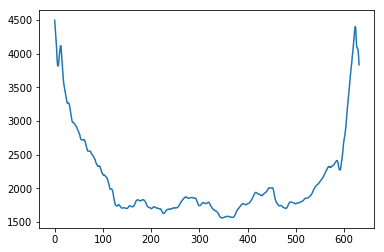

In [74]:
# The raw change-point statistics, using L1 norm
plt.plot(raw_matrix_change_point(ts, l1_vec_norm))

In [75]:
# Computes normalized statistic and p-values
loc, pval, stats_cal, stats0_cal, sts, cor1, cor2 = bootstrapped_matrix_change_point(ts, l1_vec_norm, 10, 100)

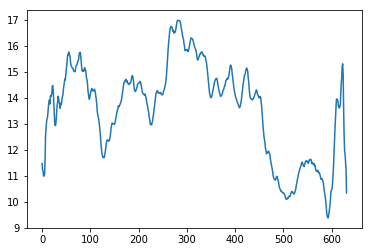

In [80]:
# The normalized statistics downweight the beginning and end values, which are more variable
plt.plot(stats0_cal[0,:])

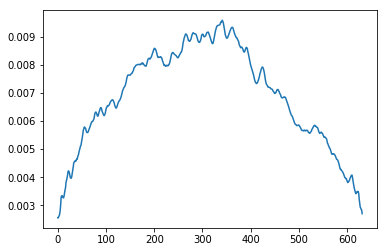

In [81]:
# These are the weightings used to normalize the change-point scores
plt.plot(1/sts[0,:])

In [82]:
# The candidate change time
loc

281

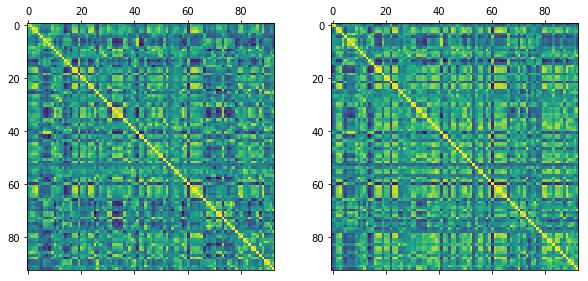

In [83]:
# The correlations before and after
plt.figure(figsize = (10,10))
ax = plt.subplot(2,2,1)
ax.matshow(cor1)
ax = plt.subplot(2,2,2)
ax.matshow(cor2)
# Do they look different?

In [84]:
# What's the p-value?
pval

0.0099009900990099011

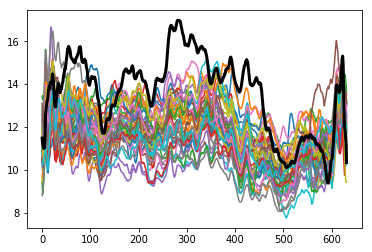

In [87]:
# The normalized statistics (black) vs the normalized stats of the null bootstraps (other colors)
for i in range(40):
    plt.plot(stats_cal[i,:])
plt.plot(stats0_cal[0,:], color='k', linewidth=3)
